In [1]:
import keras_tuner as kt 
from sklearn.feature_selection import RFE, RFECV
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization, Input
import numpy as np
import datetime
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
np.random.seed(42)

In [2]:
# The training data.
train = pd.read_csv('../data/Train.csv')
test = pd.read_csv('../data/Test.csv')
ss = pd.read_csv('../data/SampleSubmission.csv')
train.shape, test.shape


# // The training data has many features so that could lead to a curse of dimensionality 
    # // dimentionality reduction - PCA and other methods
    # // feature selection for importance features ()

((83148, 29), (25584, 28))

In [3]:
# // only the target is not present in the testing set
    # // there is no column mismatch

for column in train.columns:
    if column not in test.columns:
        print(column)

burn_area


In [4]:
# // Investigate missing values
    # // There are no missing values

train.isnull().any().any(), test.isnull().any().any(), ss.isnull().any().any()

(False, False, False)

In [5]:
# Look at distribution of each variable
train.describe()

,lat,lon,burn_area,climate_aet,climate_def,climate_pdsi,climate_pet,climate_pr,climate_ro,climate_soil,...,landcover_0,landcover_1,landcover_2,landcover_3,landcover_4,landcover_5,landcover_6,landcover_7,landcover_8,precipitation
count,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,...,83148.000000,83148.000000,83148.000000,8.314800e+04,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000,83148.000000
mean,-19.014557,29.860856,0.007632,484.491124,828.892721,-30.806237,1313.382992,54.576322,6.215134,305.477919,...,0.006158,0.000017,0.008583,4.066313e-08,0.160628,0.037453,0.785382,0.000354,0.001424,0.078551
std,1.588444,1.751090,0.029226,470.467480,546.934469,235.802930,315.209838,71.997561,21.480399,400.956123,...,0.053111,0.000141,0.059046,3.535121e-06,0.192957,0.106050,0.233953,0.001773,0.014233,0.104464
min,-22.358835,25.487029,0.000000,0.000000,0.000000,-563.000000,587.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000
25%,-20.358835,28.487029,0.000000,50.000000,375.000000,-212.000000,1081.000000,1.000000,0.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.014993,0.000000,0.655322,0.000000,0.000000,0.002017
50%,-18.858835,29.987029,0.000000,302.000000,858.000000,-108.000000,1290.000000,22.000000,1.000000,149.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.076706,0.000139,0.880600,0.000000,0.000000,0.028503
75%,-17.858835,31.237029,0.000000,931.000000,1211.000000,142.000000,1517.000000,87.000000,4.000000,329.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.246498,0.015166,0.971209,0.000000,0.000000,0.125500
max,-15.858835,32.987029,0.843886,1713.000000,2614.000000,851.000000,2620.000000,501.000000,342.000000,3319.000000,...,0.828131,0.004918,0.711603,3.073689e-04,0.981472,0.881323,1.000000,0.016708,0.301823,0.801328


The skew value for the label is:  7.675599412401078


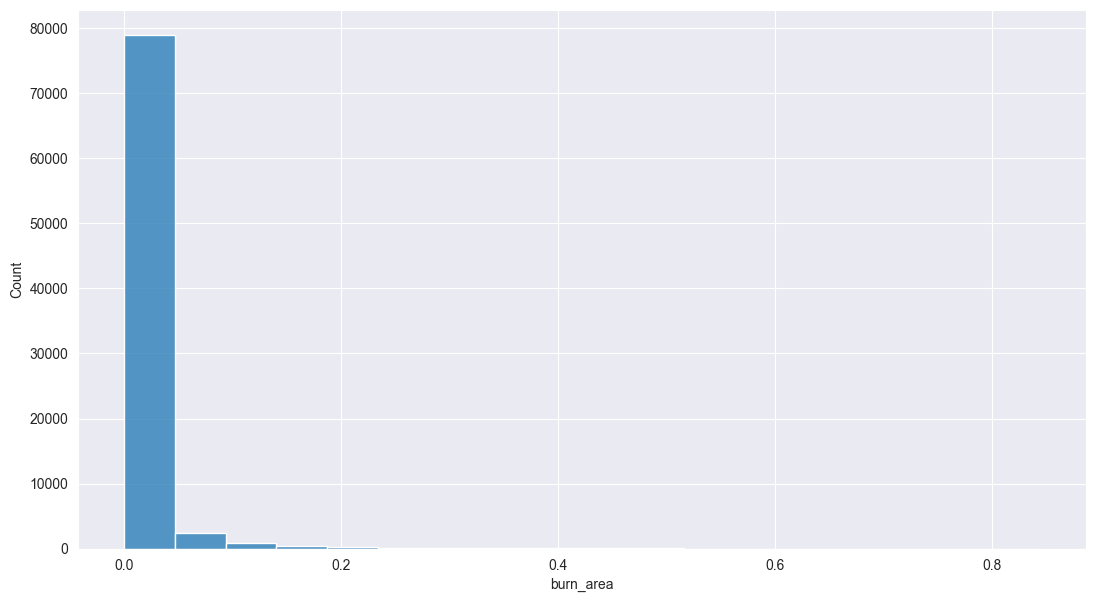

In [6]:
# // The target is highly skewed
    # // we need to transform it

print(f'The skew value for the label is:  {train.burn_area.skew()}')

sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.burn_area)
plt.show()

In [7]:
# // Investigate some transformation techniques

print(np.log1p(train.burn_area).skew())
print(np.cbrt(train.burn_area).skew())
print(np.sqrt(train.burn_area).skew())
print((train.burn_area ** float(1/1024)).skew()) # This is the optimal one

6.643186378864086
2.2837509973123558
3.200003493842135
1.2592819360219192


After transformation  the skew value for the label is:  1.2592819360219192


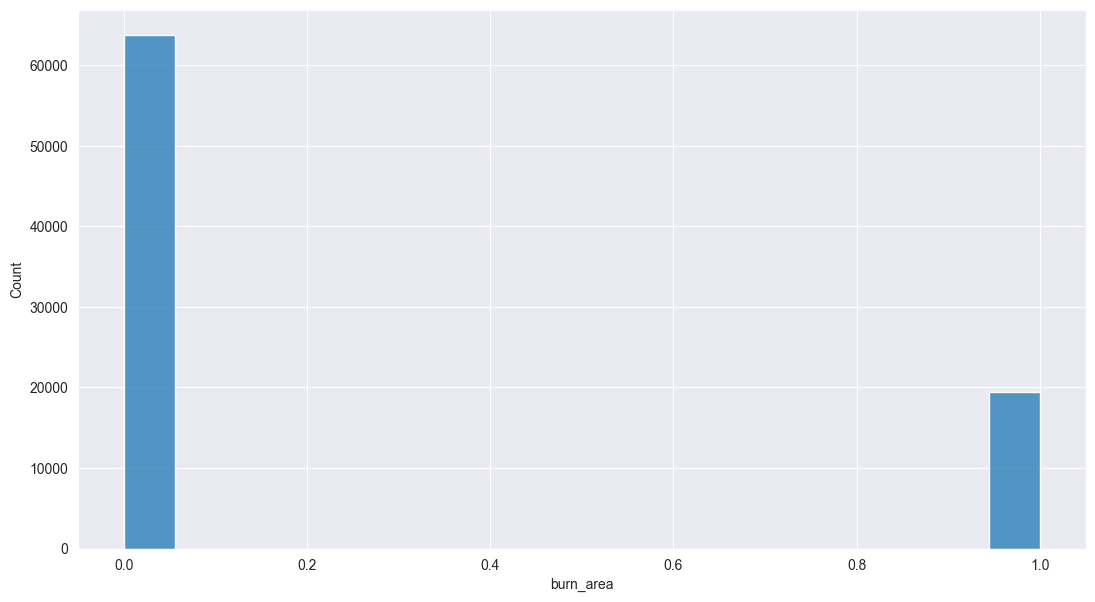

In [8]:
# // The target is highly skewed
    # // we need to transform it

print(f'After transformation  the skew value for the label is:  {(train.burn_area ** float(1/1024)).skew()}')

sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(train.burn_area ** float(1/1024))
plt.show()

<Axes: >

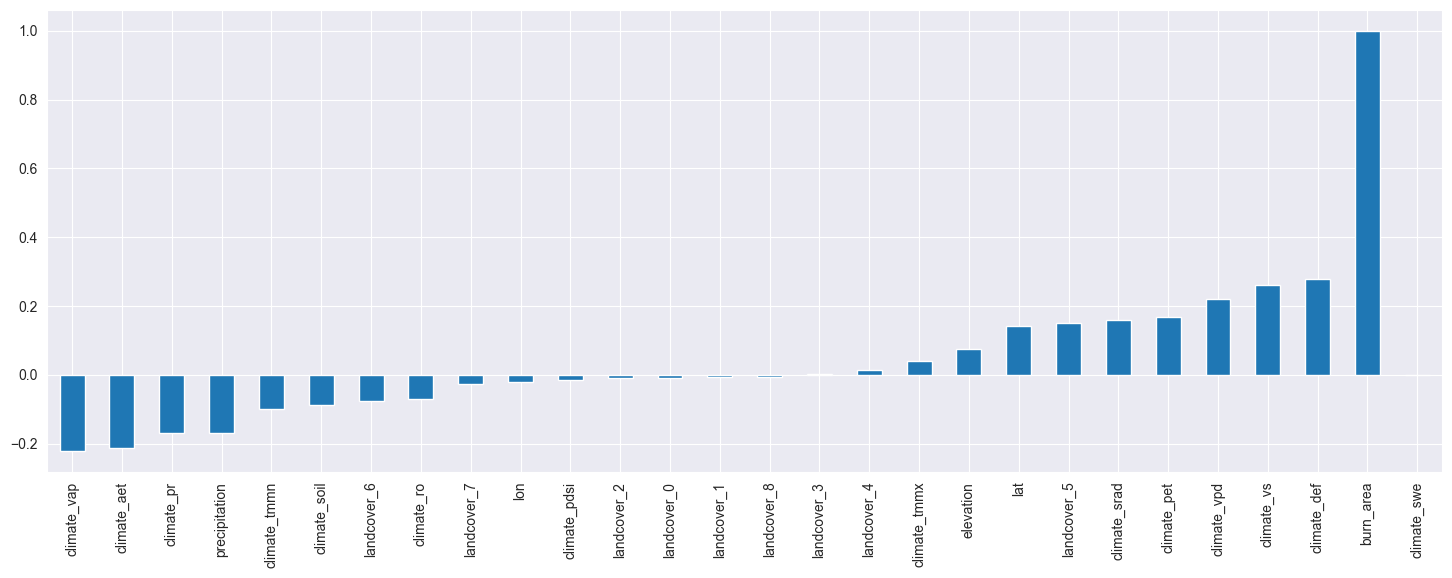

In [9]:
# Look at correlation with target
train.select_dtypes(include=['number']).corr()['burn_area'].sort_values().plot(kind='bar', figsize=(18, 6))

##  Adding date features

In [10]:
# //  Date variables

# train['burn_area'] = train.burn_area ** float(1/1024)
train['date'] = pd.to_datetime(train['ID'].apply(lambda x: x.split('_')[1]))
train['burn_area'] = pd.to_numeric(train['burn_area'], errors='coerce')

train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['day'] = train.date.dt.weekday
train['quarter'] = train.date.dt.quarter
train['dayofmonth'] = train.date.dt.day
train['dayofyear'] = train.date.dt.dayofyear
train['weekofyear'] = train.date.dt.isocalendar().week


In [11]:
# // Add lag featues to make it time series



## Utility Functions

In [12]:
# // Scaling

def scaler(X_train, X_test, minmax: bool=False):
    stdscaler = StandardScaler()
    X_train = stdscaler.fit_transform(X_train)
    X_test = stdscaler.transform(X_test)

    if minmax:
        minmaxscaler = MinMaxScaler(feature_range=(0,1))
        X_train = minmaxscaler.fit_transform(X_train)
        X_test = minmaxscaler.transform(X_test)
    return X_train, X_test


# // feature selection

def feature_selection(X_train, X_test, y_train, index: int=train.shape[1]) -> tuple:
    sel = RFE(
        estimator=RandomForestRegressor(
            n_estimators=100, random_state=42, n_jobs=-1
        ),
        n_features_to_select=index
    )
    sel.fit(X_train, y_train)
    X_train_rfe = sel.transform(X_train) 
    X_test_rfe = sel.transform(X_test)
    return X_train_rfe, X_test_rfe


# // Discretization

def binning(data: pd.DataFrame) -> pd.DataFrame:
    def optimal_k(data: pd.DataFrame, column: str, max_k: int=10):
        silhouette_scores = []
        X = data[column].values.reshape(-1, 1)
        for k in range(2, max_k+1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(X)
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)
            optimal_k = range(2, max_k+1)[silhouette_scores.index(max(silhouette_scores))]
        return optimal_k

    numerics = []
    for i in data.columns:
        if data[i].dtype == 'float':
            numerics.append(i)

    for column in numerics:
        if column != 'burn_area':
            k = optimal_k(data, column)
            reshaped_data = data[column].values.reshape(-1, 1)
            kmeans = KMeans(n_clusters=k, random_state=42)
            data[column] = kmeans.fit_predict(reshaped_data)
    return data


# // Handling outliers
    # // find other methods as well


def capping(data: pd.DataFrame, numerics=[]) -> pd.DataFrame:
    for col in numerics:
        if col != 'burn_area':
            q1 = data[col].quantile(0.25)
            q2 = data[col].quantile(0.75)
            iqr = q2 - q1
            max_limit = q2 + (1.5 * iqr)
            min_limit = q1 - (1.5 * iqr)
            data[col]  = pd.DataFrame(
                np.where(data[col] > max_limit, max_limit,
                (np.where(data[col] < min_limit, min_limit, data[col]))), columns=[col]
            )
    return data


# // Get the best model

def best_model(errors):
    scores = []
    for model in errors:
        scores.append(model['score'])
    for model in errors:
        if model['score'] == min(scores):
            return model['model']

## Machine Learning

In [13]:
# // data splicing


in_cols = []
target_col = 'burn_area'
for column in train.columns:
       if column != target_col:
              in_cols.append(column)

in_cols.remove('date')
in_cols.remove('ID')

train_all = train.copy().dropna()
train = train_all.loc[train_all.date < '2011-01-01']
valid = train_all.loc[train_all.date >= '2011-01-01']


X_train, y_train = train[in_cols], train[target_col]
X_valid, y_valid = valid[in_cols], valid[target_col]

In [14]:
# # // Get Feature Selection Index Value from diagram

# visualizer = RFECV(
#     GradientBoostingRegressor(
#         random_state=42,
#         criterion='squared_error',
#         loss='squared_error',
#         alpha=.1
#     ),
#     step=1, cv=3, scoring="neg_root_mean_squared_log_error"
# )
# visualizer.fit(X_train, y_train)
# plt.figure(figsize=[5.6, 4])
# visualizer.show()


In [15]:
# // Crucial Variables

cap_data=False
bin_data=False
select_data=False
scale_data=False
reduce_dimension=False
n=2
index=10
minmax=False

In [16]:
# // apply utility
    # // capping outliers
    # // discretization
    # // feature selection
    # // Normalization
    # // PCA


if cap_data:
    train = capping(train)

if bin_data:
    train_binned = binning(train)

if select_data:
    X_train, X_valid = feature_selection(X_train, X_valid, y_train, index=index)

if scale_data:
    X_train, X_valid = scaler(X_train=X_train, X_test=X_valid, minmax=minmax)

if reduce_dimension:
    pca = PCA(n_components=n, random_state=42)
    pca = pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_valid = pca.transform(X_valid)

In [17]:

# // Train a couple of models


errors = []


random_F = RandomForestRegressor(
    random_state=42,
    criterion='squared_error',
    bootstrap=True,
    max_features='sqrt',
    warm_start=True
)
random_F.fit(X_train, y_train)
preds = random_F.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
errors.append({"model": "RandomForest", 'score': rmse})
print("The RandomForest error is {}".format(rmse))


gbr = GradientBoostingRegressor(
    random_state=42,
    criterion='squared_error',
    loss='squared_error',
    alpha=.1,
    warm_start=True
)
gbr.fit(X_train, y_train)
preds = gbr.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
errors.append({"model": "GradientBoosting", 'score': rmse})
print("The GradientBoostingRegressor error is {}".format(rmse))


ada = AdaBoostRegressor(
    random_state=42,
    estimator=gbr,
    learning_rate=1e-4,
    loss='square',
    n_estimators=100
)
ada.fit(X_train, y_train)
preds = ada.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
errors.append({"model": "AdaBoost", 'score': rmse})
print("The AdaBoost with Gradient Boosting error is {}".format(rmse))


ada_rf = AdaBoostRegressor(
    random_state=42,
    estimator=random_F,
    learning_rate=1e-4,
    loss='square',
    n_estimators=100
)
ada_rf.fit(X_train, y_train)
preds = ada_rf.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
errors.append({"model": "AdaBoostForest", 'score': rmse})
print("The AdaBoost with RandomForest error is {}".format(rmse))



ada_DT = AdaBoostRegressor(
    random_state=42,
    estimator=DecisionTreeRegressor(
        criterion="squared_error",
        random_state=42,
        max_features='sqrt'
    ),
    learning_rate=1e-4,
    loss='square',
    n_estimators=100
)
ada_DT.fit(X_train, y_train)
preds = ada_DT.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
errors.append({"model": "AdaBoostDT", 'score': rmse})
print("The AdaBoost with DecisionTreeRegressor error is {}".format(rmse))


ada_ada = AdaBoostRegressor(
    random_state=42,
    estimator=ada_DT,
    learning_rate=1e-4,
    loss='square',
    n_estimators=100
)
ada_ada.fit(X_train, y_train)
preds = ada_ada.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
errors.append({"model": "AdaBoostADA", 'score': rmse})
print("The AdaBoost with AdaBoost error is {}".format(rmse))

The RandomForest error is 0.02356459854000995
The XGBRegressor error is 0.028494184820257583
The GradientBoostingRegressor error is 0.02407632471748844
The AdaBoost with Gradient Boosting error is 0.02390283684077889
The AdaBoost with RandomForest error is 0.023251170411778044
The AdaBoost with DecisionTreeRegressor error is 0.022434627076341997
The AdaBoost with AdaBoost error is 0.02248335596707703


In [18]:
# # // Hyper-parameter tuning
#     # // only apply hyper-parameter tuning to these models
#         # GradientBoostingRegressor
#         # AdaBoost with Decision Tree
#         # AdaBoost with Gradient Boosting
#         # AdaBoost with adaboost


# def grid_search(model, params):
#     grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#     grid.fit(X_train, y_train)
#     return grid.best_estimator_, grid.best_params_, np.sqrt(-grid.best_score_)


# models = {
#     "Gradient Boosting Regression": {
#         "model": GradientBoostingRegressor(
#             random_state=42,
#             criterion='squared_error'
#         ),
#         "params": {
#             "n_estimators": [100, 200],
#             "learning_rate": [0.01, 0.1],
#             "max_depth": [3, 5, 7]
#         }
#     }
# }


# results = {}
# for name, config in models.items():
#     model, params, score = grid_search(config['model'], config['params'])
#     results[name] = {'Best Model': model, 'Best Params': params, 'RMSE': score}


# for name, result in results.items():
#     print(f"{name} - Best Params: {result['Best Params']}, RMSE: {result['RMSE']}")


# best_model_name = min(results, key=lambda x: results[x]['RMSE'])
# tuned_ml_best_model = results[best_model_name]['Best Model']
# test_rmse = np.sqrt(mean_squared_error(y_valid, tuned_ml_best_model.predict(X_valid)))
# errors.append({'model': best_model_name, "score": test_rmse})

# print(f"\nBest Model: {best_model_name}")
# print(f"Test RMSE: {test_rmse}")

## Deep Learning

In [19]:


# input_dim = X_train.shape[1]
# noise_factor = 0.1
# X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
# X_test_noisy = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape)
# X_train_noisy = np.clip(X_train_noisy, 0., 1.)
# X_test_noisy = np.clip(X_test_noisy, 0., 1.)


# input_data = Input(shape=(input_dim,))
# encoded = Dense(128, activation='relu')(input_data)
# encoded = Dense(64, activation='relu')(encoded)
# encoded = Dense(32, activation='relu')(encoded)
# decoded = Dense(64, activation='relu')(encoded)
# decoded = Dense(128, activation='relu')(decoded)
# decoded = Dense(input_dim, activation='sigmoid')(decoded)
# autoencoder = Model(input_data, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.fit(X_train_noisy, X_train,
#                 epochs=50,
#                 batch_size=256,
#                 shuffle=True,
#                 validation_data=(X_test_noisy, X_valid))


# encoder = Model(input_data, encoded)
# X_train_encoded = encoder.predict(X_train_noisy)
# X_valid_encoded = encoder.predict(X_test_noisy)


# model = Sequential()
# model.add(Dense(units=512, activation='relu', input_shape=(X_train_encoded.shape[1],)))
# model.add(BatchNormalization())
# model.add(Dropout(rate=0.2))
# model.add(Dense(units=64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(units=32, activation='relu'))
# model.add(Dense(1, activation='linear'))

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
# model.fit(X_train_encoded, y_train, epochs=50, batch_size=256, validation_data=(X_valid_encoded, y_valid))


# preds = model.predict(X_valid_encoded)
# rmse = mean_squared_error(y_valid, preds)**0.5
# errors.append({"model": "ANN", 'score': rmse})
# print(f'RMSE: {rmse}')


In [20]:
# # // Hyper-parameter tuning - Keras-tuner



# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(
#         units=hp.Int('units_1', min_value=128, max_value=512, step=32),
#         activation='relu', 
#         input_shape=(X_train_encoded.shape[1],)
#     ))
#     model.add(BatchNormalization())
#     model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(Dense(
#         units=hp.Int('units_2', min_value=32, max_value=128, step=32),
#         activation='relu'
#     ))
#     model.add(BatchNormalization())
#     model.add(Dense(
#         units=hp.Int('units_3', min_value=16, max_value=64, step=16),
#         activation='relu'
#     ))
#     model.add(Dense(1, activation='linear'))
#     model.compile(
#         optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
#         loss='mean_squared_error'
#     )
#     return model


# tuner = kt.Hyperband(
#     build_model,
#     objective='val_loss',
#     max_epochs=50,
#     factor=3,
#     directory='my_dir',
#     project_name='hyperparameter_tuning'
# )

# tuner.search(X_train_encoded, y_train, epochs=50, validation_data=(X_valid_encoded, y_valid))
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# tuned_model = tuner.hypermodel.build(best_hps)
# history = tuned_model.fit(X_train_encoded, y_train, epochs=50, validation_data=(X_valid_encoded, y_valid))
# preds = tuned_model.predict(X_valid_encoded)
# rmse = np.sqrt(mean_squared_error(y_valid, preds))
# errors.append({"model": "Tuned ANN", 'score': rmse})

# Submission

In [21]:
# // get best model


best = best_model(errors=errors)
if best == "RandomForest":
    model = random_F
elif best == 'AdaBoost':
    model = ada
# elif best == best_model_name:
#     model = tuned_ml_best_model
elif best == 'GradientBoosting':
    model = gbr
elif best == 'AdaBoostForest':
    model = ada_rf
elif best == 'AdaBoostDT':
    model = ada_DT
elif best == 'AdaBoostADA':
    model = ada_ada

In [22]:
# // Working with the testing data


test['date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split('_')[1]))
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['day'] = test.date.dt.weekday
test['quarter'] = test.date.dt.quarter
test['dayofmonth'] = test.date.dt.day
test['dayofyear'] = test.date.dt.dayofyear
test['weekofyear'] = test.date.dt.isocalendar().week
test = test.drop(['date'], axis=1)
test = test.drop(['ID'], axis=1)

if cap_data:
    test = capping(test)

if bin_data:
    test_binned = binning(test)

if reduce_dimension:
    test = pca.transform(test[in_cols]) 
    preds = model.predict(test)
else:
    preds = model.predict(test)


ss['burn_area'] = preds
ss['burn_area'] = ss['burn_area'].clip(0, 1)
today = datetime.date.today()
value = '01'
ss.to_csv(f'{today}_submit_{value}.csv', index=False)